# 1. Configuração de Ambiente

Imports agrupados por tipo e carregamento das variáveis de ambiente.


In [1]:
# %% Imports padrão
import os
import sys
from pathlib import Path
from datetime import datetime
import json
import shutil
import time

# %% Imports de Data Science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, model_selection

# %% Imports Auto-sklearn
import autosklearn.classification
import autosklearn.metrics

# %% Imports Banco de Dados
from pymongo import MongoClient

# %% Variáveis de ambiente / paths
sys.path.insert(0, os.path.abspath(os.path.join('..', 'src')))
from dotenv import load_dotenv
load_dotenv(dotenv_path='../.env')

MONGO_URI = os.getenv('MONGODB_CONNECTION_STRING')
MONGO_DB = os.getenv('MONGODB_DB')
MONGO_COLLECTION = os.getenv('MONGODB_COLLECTION')

/home/joao/miniconda3/envs/as-env/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore


# 2. Carregamento e Pré-processamento de Dados

Carrega o dataset (definido por variável), divide em treino e teste e prepara diretórios temporários.


In [2]:
# %% Configurações de dataset
DATASET_NAME = 'iris'
RANDOM_STATE = 1

# %% Carregamento
X, y = datasets.fetch_openml(name=DATASET_NAME, version=1, return_X_y=True, as_frame=True)

# %% Split
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, random_state=RANDOM_STATE, stratify=y
)

# %% Diretórios temporários
TMP_ROOT = Path('../results/tmp') / DATASET_NAME
if TMP_ROOT.exists():
    shutil.rmtree(TMP_ROOT)

# 3. Configuração e Execução do AutoSklearn

Funções utilitárias para rodar o AutoSklearn com ou sem ensemble e coletar informações essenciais do processo.


In [3]:
# %% Parâmetros Auto-sklearn
TIME_LIMIT_SEC = 45 * 1
METRIC_SK = autosklearn.metrics.f1_weighted

def run_autosklearn(with_ensemble: bool, tmp_dir: Path):
    automl = autosklearn.classification.AutoSklearnClassifier(
        time_left_for_this_task=TIME_LIMIT_SEC,
        per_run_time_limit=int(TIME_LIMIT_SEC / 10),
        tmp_folder=str(tmp_dir),
        seed=RANDOM_STATE,
        metric=METRIC_SK,
        ensemble_kwargs={'ensemble_size': 50 if with_ensemble else 1}
    )
    automl.fit(X_train, y_train)
    return automl

def extract_leaderboard(automl):
    lb = automl.leaderboard(detailed=True, ensemble_only=True).sort_values('rank')
    return lb.reset_index(drop=True)

def serialize_models(automl, leaderboard_df):
    models_serialized = []
    for (_, row), (weight, pipeline) in zip(
        leaderboard_df.iterrows(),
        automl.get_models_with_weights()
    ):
        steps_info = {}
        for name, step in pipeline.steps:
            estimator = step.choice if hasattr(step, 'choice') else step
            try:
                raw_params = estimator.get_params(deep=False)
            except AttributeError:
                raw_params = {}
            params = {
                k: v
                for k, v in raw_params.items()
                if isinstance(v, (int, float, str, bool, type(None)))
            }
            steps_info[name] = {
                'algorithm': estimator.__class__.__name__,
                'parameters': params
            }

        models_serialized.append({
            'weight': float(weight),
            'cost':   float(row['cost']),
            'classifier':          steps_info.get('classifier', {}),
            'data_preprocessor':   steps_info.get('data_preprocessor', {}),
            'feature_preprocessor':steps_info.get('feature_preprocessor', {})
        })

    return {
        'total_models': len(models_serialized),
        'models':       models_serialized
    }

# 4. Avaliação de Métricas

Calcula métricas principais, matriz de confusão normalizada, gera dados para curva de aprendizado e evolução temporal.


In [4]:
def evaluate_metrics(automl):
    y_pred = automl.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = metrics.recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1w = metrics.f1_score(y_test, y_pred, average='weighted', zero_division=0)
    cm = metrics.confusion_matrix(y_test, y_pred, normalize='true').tolist()
    return {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'balanced_f1': float(f1w),
        'confusion_matrix': cm
    }

def collect_performance_over_time(automl):
    df = automl.performance_over_time_.copy()
    cols = [c for c in df.columns if c not in ('num_models_trained',)]
    return {c: df[c].tolist() for c in cols}

def compute_learning_curve(estimator, X_tr, y_tr, scoring):
    sizes, train_scores, val_scores = model_selection.learning_curve(
        estimator, X_tr, y_tr, cv=5, scoring=scoring, n_jobs=1,
        train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=RANDOM_STATE
    )
    return {
        'train_sizes': sizes.tolist(),
        'train_scores_mean': np.mean(train_scores, axis=1).tolist(),
        'val_scores_mean': np.mean(val_scores, axis=1).tolist()
    }


# 5. Salvamento dos Resultados no MongoDB

Constrói o documento JSON final (no padrão especificado) e insere na coleção MongoDB.


In [5]:
def build_document(automl, leaderboard_df, with_ensemble: bool):
    metrics_obj = evaluate_metrics(automl)
    model_obj = serialize_models(automl, leaderboard_df)
    perf_time = collect_performance_over_time(automl)
    #lc_data = compute_learning_curve(automl, X_train, y_train, scoring='f1_weighted')
    return {
        'timeStamp': datetime.now().astimezone().isoformat(),
        'dataset': DATASET_NAME,
        'automl': 'autosklearn',
        'with_ensemble': with_ensemble,
        'metrics': metrics_obj,
        'model': {
            **model_obj,
            'graphic': {
                'performance_over_time': perf_time,
                'learning_curve': None
            }
        }
    }

def mongo_insert(doc: dict):
    client = None
    try:
        client = MongoClient(MONGO_URI, serverSelectionTimeoutMS=5000)
        collection = client[MONGO_DB][MONGO_COLLECTION]
        res = collection.insert_one(doc)
        return str(res.inserted_id)
    except Exception as e:
        print(f"Erro ao inserir no MongoDB: {e}")
        return None
    finally:
        if client:
            client.close()


# Execução

Roda com e sem ensemble, monta documentos e insere no MongoDB.


In [6]:
# %% Execução paralela limpa
import concurrent.futures, time, warnings, logging

warnings.filterwarnings("ignore", message=".*cost of smaller/equal to 0.*")

def workflow(with_ens: bool, label: str):
    folder = TMP_ROOT / label
    automl = run_autosklearn(with_ens, folder)
    lb     = extract_leaderboard(automl)
    doc    = build_document(automl, lb, with_ens)
    #mongo  = mongo_insert(doc)
    return label, {'doc': doc, 'mongo_id': None, 'automl': automl, 'leaderboard': lb}

start = time.time()
RESULTS = {}

with concurrent.futures.ProcessPoolExecutor(max_workers=2) as pool:
    futures = [
        pool.submit(workflow, True , 'with_ensemble'),
        pool.submit(workflow, False, 'without_ensemble')
    ]
    for fut in concurrent.futures.as_completed(futures):
        label, data = fut.result()
        RESULTS[label] = data

print(f'Tempo total: {time.time()-start:.1f}s')
RESULTS.keys()

/home/joao/miniconda3/envs/as-env/lib/python3.9/site-packages/autosklearn/data/target_validator.py:187: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  warnings.warn(
/home/joao/miniconda3/envs/as-env/lib/python3.9/site-packages/autosklearn/data/target_validator.py:187: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  warnings.warn(
/home/joao/miniconda3/envs/as-env/lib/python3.9/site-packages/autosklearn/automl.py:1860: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pd.merge(
/home/joao/miniconda3/envs/as-env/lib/python3.9/site-packages/autosklearn/automl.py:1860: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.

Tempo total: 39.7s


dict_keys(['without_ensemble', 'with_ensemble'])

# Visualizações



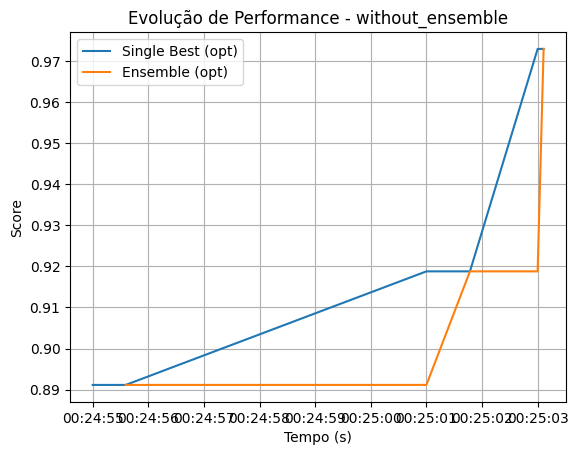

/tmp/ipykernel_92781/1464892743.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


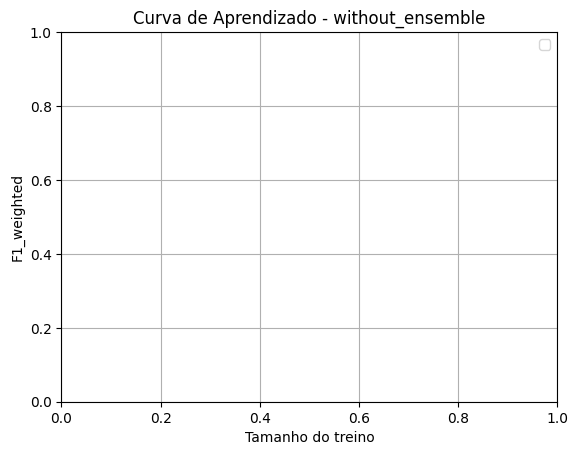

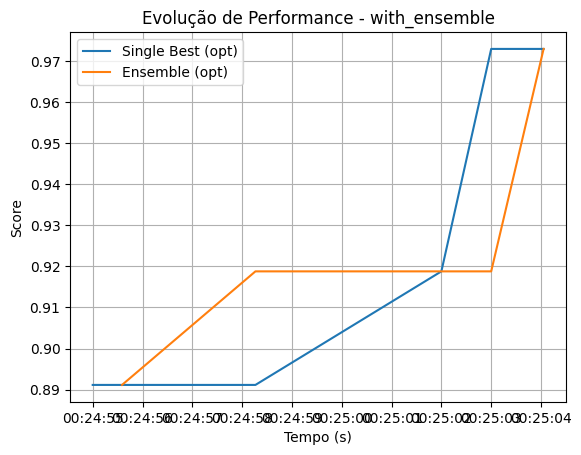

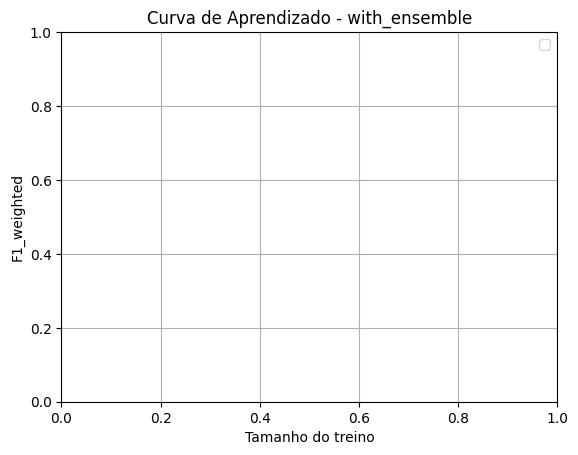

In [8]:
for label, item in RESULTS.items():
    perf = item['doc']['model']['graphic']['performance_over_time']
    plt.figure()
    plt.plot(perf['Timestamp'], perf['single_best_optimization_score'], label='Single Best (opt)')
    if 'ensemble_optimization_score' in perf:
        plt.plot(perf['Timestamp'], perf['ensemble_optimization_score'], label='Ensemble (opt)')
    plt.title(f'Evolução de Performance - {label}')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    lc = item['doc']['model']['graphic']['learning_curve']
    plt.figure()
    # plt.plot(lc['train_sizes'], lc['train_scores_mean'], 'o-', label='Treino')
    # plt.plot(lc['train_sizes'], lc['val_scores_mean'], 'o-', label='Validação')
    plt.title(f'Curva de Aprendizado - {label}')
    plt.xlabel('Tamanho do treino')
    plt.ylabel('F1_weighted')
    plt.legend()
    plt.grid(True)
    plt.show()
